In [1]:
# this cell contains code to build the flower 
# source https://www.tensorflow.org/tutorials/load_data/images
import pathlib
import random
import os

import tensorflow as tf
import IPython.display as display
tf.enable_eager_execution()
tf.__version__

print("downloading images")
data_root_orig = tf.keras.utils.get_file('flower_photos',
                                         'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)

print("images are stored in {}".format(data_root))
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
image_count = len(all_image_paths)
print("there are {} images".format(image_count))

attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

def change_range(image,label):
  return 2*image-1, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

BATCH_SIZE = 32

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False


keras_ds = ds.map(change_range)
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

model.summary()
model.fit(ds, epochs=1, steps_per_epoch=3)

downloading images
images are stored in /root/.keras/datasets/flower_photos
there are 3670 images


W0816 13:29:36.693036 140665099556224 deprecation.py:323] From <ipython-input-1-8ae9e996a113>:60: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


W0816 13:29:50.163961 140665099556224 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/3 [==============================] - 26s 9s/step - loss: 8.4830 - acc: 0.1562


In [2]:
# deploy the fitted model to omega|ml 
import numpy as np
import omegaml as om 

om.models.put(model, 'tfkeras-flower')

<Metadata: Metadata(name=tfkeras-flower,bucket=omegaml,prefix=models/,kind=tfkeras.h5,created=2019-08-16 13:20:44.277000)>

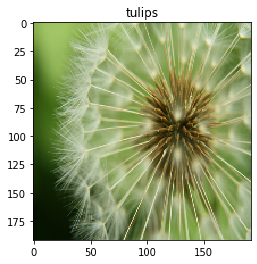

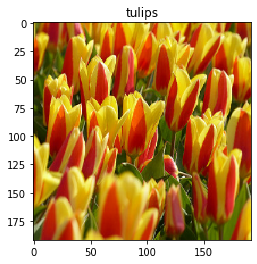

In [3]:
# use the model for prediction (Python API)
%matplotlib inline
from matplotlib import pyplot as plt

# loading the model can take some time
model_ = om.models.get('tfkeras-flower')

for img in image_ds.take(2):
    result = model_.predict(np.array([img.numpy()]))
    label = label_names[np.argmax(result)]
    fig = plt.figure()
    plt.title(label)
    plt.imshow(img)

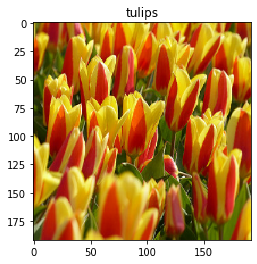

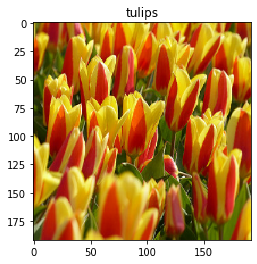

In [4]:
# start async prediction
results = []
for img in image_ds.take(2):
    result = om.runtime.model('tfkeras-flower').predict(np.array([img.numpy()]))
    results.append(result)
    
# get results and show
for result in results:
    label = label_names[np.argmax(result.get())]
    fig = plt.figure()
    plt.title(label)
    plt.imshow(img)

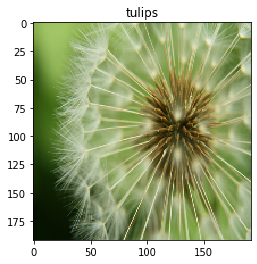

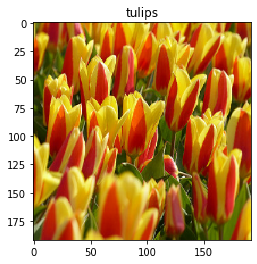

In [5]:
# REST API

%load_ext autoreload
%autoreload 2

import requests
from omegaml.client.auth import OmegaRestApiAuth

# -- setup authentication and API URL
auth = OmegaRestApiAuth.make_from(om)
base_url = getattr(om.defaults, 'OMEGA_RESTAPI_URL', 'http://localhost:5000')

predict_url = '{base_url}/api/v1/model/tfkeras-flower/predict'.format(**locals())

for img in image_ds.take(2):
    # take picture
    imgdata = img.numpy()
    # predict 
    resp = requests.put(predict_url, json={
                'columns': ['x'],
                'data': [{'x': imgdata.flatten().tolist()}],
                'shape': [192, 192, 3],
          }, auth=auth)
    # show result
    data = resp.json()
    prediction = data['result']
    label = label_names[np.argmax(prediction)]
    fig = plt.figure()
    plt.title(label)
    plt.imshow(imgdata)

In [6]:
# save model as a a Tensorflow SavedModel
# -- note this may print several tensorflow warnings due to deprecated functionality 
model_ = om.models.get('tfkeras-flower')
om.models.put(model_, 'tfkeras-flower-savedmodel', as_savedmodel=True)

<Metadata: Metadata(name=tfkeras-flower-savedmodel,bucket=omegaml,prefix=models/,kind=tfkeras.savedmodel,created=2019-08-16 13:22:36.593000)>

http://localhost:5000/api/v1/model/tfkeras-flower-savedmodel/predict


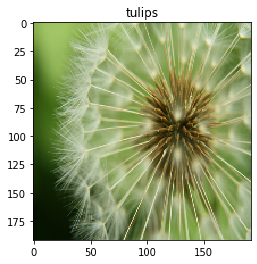

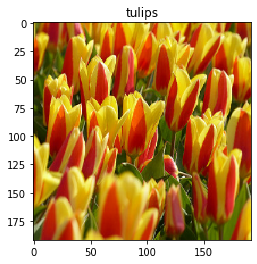

In [7]:
# use the SavedModel instance
import omegaml as om
import requests

from omegaml.client.auth import OmegaRestApiAuth
import omegaml as om 

# -- setup authentication and API URL
auth = OmegaRestApiAuth.make_from(om)
base_url = getattr(om.defaults, 'OMEGA_RESTAPI_URL', 'http://localhost:5000')
predict_url = '{base_url}/api/v1/model/tfkeras-flower-savedmodel/predict'.format(**locals())

print(predict_url)

for img in image_ds.take(2):
    # take picture
    imgdata = img.numpy()
    # predict 
    resp = requests.put(predict_url, json={
                'columns': ['x'],
                'data': [{'x': imgdata.flatten().tolist()}],
                'shape': [192, 192, 3],
          }, auth=auth)
    # show result
    data = resp.json()
    prediction = data['result']
    label = label_names[np.argmax(prediction)]
    fig = plt.figure()
    plt.title(label)
    plt.imshow(imgdata)

In [8]:
print(label_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [9]:
# use a virtualobj to perform business logic on model input and output 
from omegaml.backends.virtualobj import virtualobj

@virtualobj
def mymodel(data=None, method=None, meta=None, store=None, **kwargs):
    # in a virutalobj handler, always import modules locally
    import numpy as np
    models = store
    if method == 'predict':
        label_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
        # do some pre-processing, e.g. to ensure the shape matches the model input layer
        X = np.array([data])
        # pass on to the model in required input shape
        result = models.get('tfkeras-flower-savedmodel').predict(X)
        # return labels instead of numeric result
        return label_names[np.argmax(result)]


# store an image 
for img in image_ds.take(1):
    om.datasets.put(img.numpy(), 'image')

# store the virtualobj handler as a model
om.models.drop('mymodel', force=True)
om.models.put(mymodel, 'mymodel')

# use the model REST API using the stored image
modelname = 'mymodel'
dataset = 'image'
predict_url = '{base_url}/api/v1/model/{modelname}/predict?datax={dataset}'.format(**locals())
resp = requests.put(predict_url, auth=auth)
print(resp.json())

{'model': 'mymodel', 'result': 'tulips'}


In [10]:
# deploy an unfitted model version, fit in omega|ml runtime
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

keras_ds = ds.map(change_range)
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
om.models.put(model, 'tfkeras-flower-unfitted')

<Metadata: Metadata(name=tfkeras-flower-unfitted,bucket=omegaml,prefix=models/,kind=tfkeras.h5,created=2019-08-16 13:22:52.816000)>

In [11]:
# store images. no need to use TFExample or TFRecord (however you can if you want to)
for i, (image, label) in enumerate(image_label_ds.take(100)):
    om.datasets.put(image.numpy(), 'image-{i}-{label}'.format(i=i, label=int(label)))

In [16]:
# virutalobj that returns a tf.Dataset
@virtualobj
def trainds(data=None, method=None, meta=None, store=None, **kwargs):
    import tensorflow as tf
    datasets = store
    def get_images():
        for name in datasets.list(regexp='image-[0-255]-.*'):
            label = name.split('-')[-1]
            img = datasets.get(name)
            yield (img, label)
        
    if method == 'get':
        gen = get_images()
        output_types = (tf.int64, tf.int64)
        output_shapes = (tf.TensorShape([192, 192, 3]), tf.TensorShape([]))
        ds = tf.data.Dataset.from_generator(get_images, output_types, output_shapes)
        return ds.batch(32)

om.datasets.put(trainds, 'tfkeras-trainds', replace=True)

<Metadata: Metadata(name=tfkeras-trainds,bucket=omegaml,prefix=data/,kind=virtualobj.dill,created=2019-08-16 13:31:56.568000)>

In [17]:
# fit in cloud
om.runtime.model('tfkeras-flower-unfitted').fit('tfkeras-trainds', epochs=5).get()

<Metadata: Metadata(name=tfkeras-flower-unfitted,bucket=omegaml,prefix=models/,kind=tfkeras.h5,created=2019-08-16 13:22:52.816000)>

In [18]:
om.models.metadata('tfkeras-flower-unfitted').attributes['history']

{'loss': [8.93919849395752,
  8.579595565795898,
  8.252544403076172,
  7.93109130859375,
  7.6420159339904785],
 'acc': [0.0, 0.5, 0.5, 0.5, 0.5]}